# Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender

# Метрики
from implicit.evaluation import train_test_split
# from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

import warnings
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('retail_train.csv')
data['total_sales_value'] = data['quantity'] * data['sales_value'] 
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,total_sales_value
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,0.82
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,0.99
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1.21
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1.50


In [3]:
data['week_no'].nunique()

95

In [4]:
users, items, interactions = data.user_id.nunique(), data.item_id.nunique(), data.shape[0]

print('# users: ', users)
print('# items: ', items)
print('# interactions: ', interactions)

# users:  2499
# items:  89051
# interactions:  2396804


In [5]:
# популярность товара по продажам
popularity = data.groupby('item_id')['sales_value'].sum().reset_index()
popularity.head(3)

,item_id,sales_value
0,25671,20.94
1,26081,0.99
2,26093,1.59


In [6]:
# популярность товара среди покупателей
popularity = data.groupby('item_id')['user_id'].nunique().reset_index()
popularity.head(3)

,item_id,user_id
0,25671,3
1,26081,1
2,26093,1


### Train-test split

In [7]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_train_unsorted =data_train.copy()
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [8]:
data_train.shape[0], data_test.shape[0]

(2278490, 118314)

# 1. Бейзлайны

In [9]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(3)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [10]:
test_users = result.shape[0]
new_test_users = len(set(data_test['user_id']) - set(data_train['user_id']))

print('В тестовом дата сете {} юзеров'.format(test_users))
print('В тестовом дата сете {} новых юзеров'.format(new_test_users))

В тестовом дата сете 2042 юзеров
В тестовом дата сете 0 новых юзеров


### 1.1 Random recommendation

In [11]:
def random_recommendation(items, n=5):
    """Случайные рекомендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [12]:
items = data_train.item_id.nunique()
items

86865

In [13]:
items = data_train.item_id.unique()
result['rdm_recommendation'] = result['user_id'].apply(
    lambda x: random_recommendation(items, n=5))

### 1.2 Popularity-based recommendation

In [14]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [15]:
%%time
popular_recs = popularity_recommendation(data_train, n=5)
result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)
result.head(2)

Wall time: 130 ms


,user_id,actual,rdm_recommendation,popular_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[945595, 8019544, 5569011, 890941, 5978156]","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[393693, 10149601, 1269743, 940737, 6754898]","[6534178, 6533889, 1029743, 6534166, 1082185]"


### Item-Item Recommender

In [16]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head(3)

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1


In [17]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [18]:
data_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,total_sales_value
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,0.82
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0,0.99


In [19]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 6666
data_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,total_sales_value
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,0.82
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0,0.99


In [20]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

In [21]:
# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

In [22]:
user_item_matrix.sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100

5.33770796861036

In [23]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

### 4.2 Косинусное сходство и CosineRecommender

In [24]:
%%time

model = CosineRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)


Wall time: 767 ms


In [25]:
[id_to_itemid[rec[0]] for rec in recs]

[1082185, 6666, 981760, 1127831, 1098066]

In [26]:
%%time

result['cosine'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[6666]], 
                                    recalculate_user=True)])

Wall time: 88 ms


In [27]:
result.head(2)

,user_id,actual,rdm_recommendation,popular_recommendation,cosine
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[945595, 8019544, 5569011, 890941, 5978156]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 1098066, 961554]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[393693, 10149601, 1269743, 940737, 6754898]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 1098066, 981760, 826249, 883404]"


### 4.3 TF-IDF взвешивание и TFIDFRecommender

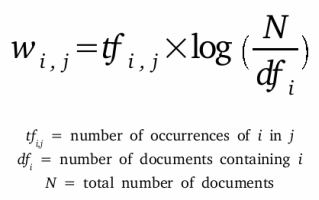

Если 2 юзера оба купили очень популярный товар, то это еще не значит,что они похожи   
Если 2 юзера оба купили редкий товар, то они похожи

Занижаем вес популярных товаров при расчете расстояний между пользователями

In [28]:
%%time

model = TFIDFRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)


Wall time: 782 ms


In [29]:
[id_to_itemid[rec[0]] for rec in recs]

[1082185, 981760, 1127831, 6666, 1098066]

In [30]:
%%time

result['tfidf'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[6666]], 
                                    recalculate_user=False)])

Wall time: 90 ms


******************************

1 Напишите код для случайных рекомендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
  - Можно сэмплировать товары случайно, но пропорционально какому-либо весу
  - Например, прямопропорционально популярности. Вес = log(sales_sum товара)
  
2 Расчет метрик

3 Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

### 1.3 Weighted random recommender

In [31]:
def weighted_random_recommendation(df_weighted_itm, n=5):
    """Случайные взвешенные рекомендации
    Input
    -----
    df_weighted_itm: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    recs = np.random.choice(df_weighted_itm.iloc[:, 0], p=df_weighted_itm.iloc[:, 1], size=n, replace=False)

    return recs.tolist()

In [32]:
def nn_recommender_test(df, user_item_matrix, id_to_itemid: dict, userid_to_id: dict, k: int = 5, n: int = 5) -> None:

    # K - кол-во билжайших соседей
    model = ItemItemRecommender(K=k, num_threads=4)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=True)

    df[f'itemitem_{k}_neighbours'] = df['user_id'].apply(lambda x: [id_to_itemid[rec[0]] for rec in
                                                                    model.recommend(userid=userid_to_id[x],
                                                                                    user_items=sparse_user_item,   # на вход user-item matrix
                                                                                    N=n,
                                                                                    filter_already_liked_items=False,
                                                                                    filter_items=[
                                                                                        itemid_to_id[6666]],
                                                                                    recalculate_user=True)])

In [33]:
# добавление случайных взвешенных рекомендаций

df_weighted_itm = data_train_unsorted.groupby(by='item_id')['total_sales_value'].sum().reset_index()
df_weighted_itm['total_sales_value'] = df_weighted_itm['total_sales_value'] / df_weighted_itm['total_sales_value'].sum()

result['rdm_rec_weighted'] = result['user_id'].apply(
    lambda x: weighted_random_recommendation(df_weighted_itm, n=5))
result.head(2)

# добавление случайных взвешенных рекомендаций топ5000

df_weighted_itm = data_train.groupby(by='item_id')['total_sales_value'].sum().reset_index()
df_weighted_itm['total_sales_value'] = df_weighted_itm['total_sales_value'] / df_weighted_itm['total_sales_value'].sum()

result['rdm_rec_weighted_5000'] = result['user_id'].apply(
    lambda x: weighted_random_recommendation(df_weighted_itm, n=5))
result.head(2)

# добавление случайных рекомендаций топ5000

items = data_train.item_id.unique()
result['rdm_recommendation_5000'] = result['user_id'].apply(
    lambda x: random_recommendation(items, n=5))

In [34]:
# проверка зависимости рекомендаций ItemItem от количества соседей
for k in [1, 2, 3, 5, 7, 10]:
    nn_recommender_test(result, user_item_matrix, id_to_itemid, userid_to_id, k=k, n=5)
    

In [35]:
result.head(3)

,user_id,actual,rdm_recommendation,popular_recommendation,cosine,tfidf,rdm_rec_weighted,rdm_rec_weighted_5000,rdm_recommendation_5000,itemitem_1_neighbours,itemitem_2_neighbours,itemitem_3_neighbours,itemitem_5_neighbours,itemitem_7_neighbours,itemitem_10_neighbours
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[945595, 8019544, 5569011, 890941, 5978156]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[6533889, 6534178, 397896, 6534166, 6544236]","[6533889, 6534178, 5703832, 6544236, 6534166]","[932503, 999563, 6548453, 990762, 1059308]","[1082185, 995242, 1029743, 840361, 904360]","[1082185, 995242, 1029743, 840361, 904360]","[1082185, 981760, 995242, 1029743, 840361]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 995242, 840361, 1127831]","[1082185, 981760, 995242, 840361, 1127831]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[393693, 10149601, 1269743, 940737, 6754898]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[6534178, 6544236, 6533889, 6534166, 1404121]","[6534178, 6533889, 6534166, 5747420, 6544236]","[1119051, 870128, 1014458, 840011, 1079820]","[1082185, 1098066, 6534178, 826249, 1127831]","[1082185, 1098066, 6534178, 826249, 1127831]","[1082185, 981760, 1098066, 6534178, 826249]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[12946140, 8204300, 891322, 1086814, 15927652]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[6544236, 6534178, 6533889, 6534166, 397896]","[6534178, 6533889, 6534166, 6544236, 480014]","[897120, 12263035, 1067849, 819643, 1015785]","[1082185, 981760, 995242, 1029743, 840361]","[1082185, 981760, 995242, 1029743, 840361]","[1082185, 981760, 995242, 1029743, 840361]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 995242, 1098066, 1127831]","[1082185, 981760, 995242, 840361, 1127831]"


# Metrics

In [36]:
from metrics import precision, recall, reciprocal_rank, ndcg_at_k, map_at_k

In [37]:
metrics_dict = {"recommendation method": [col for col in result.columns[2:]]}


metric_list = []
for name_col in result.columns[2:]:
    metric_list.append(round(result.apply(lambda row: precision(
        row[name_col], row['actual'], top_k=5), axis=1).mean(), 4))
    metrics_dict['presicion@5'] = metric_list

metric_list = []
for name_col in result.columns[2:]:
    metric_list.append(round(result.apply(lambda row: recall(
        row[name_col], row['actual'], top_k=5), axis=1).mean(), 4))
    metrics_dict['recall@5'] = metric_list

metric_list = []
for name_col in result.columns[2:]:
    metric_list.append(
        round(map_at_k(result[name_col], result['actual'], top_k=5), 4))
    metrics_dict['MAP@5'] = metric_list
    
metric_list = []
for name_col in result.columns[2:]:
    metric_list.append(round(result.apply(lambda row: ndcg_at_k(row[name_col], row['actual'], top_k=5), axis=1).mean(), 4))
    metrics_dict['NDCG@5'] = metric_list
    
metric_list = []
for name_col in result.columns[2:]:
    metric_list.append(
        round(reciprocal_rank(result[name_col], result['actual'], top_k=5), 4))
    metrics_dict['MRR@5'] = metric_list

In [38]:
df_metrics = pd.DataFrame(metrics_dict)
df_metrics

,recommendation method,presicion@5,recall@5,MAP@5,NDCG@5,MRR@5
0,rdm_recommendation,0.0007,0.0001,0.0018,0.0008,0.0018
1,popular_recommendation,0.1552,0.0250,0.2568,0.1596,0.2860
2,cosine,0.1551,0.0173,0.3845,0.1840,0.4086
3,tfidf,0.1609,0.0184,0.3854,0.1889,0.4107
4,rdm_rec_weighted,0.0460,0.0125,0.1863,0.0645,0.1875
5,rdm_rec_weighted_5000,0.0459,0.0124,0.1891,0.0657,0.1905
6,rdm_recommendation_5000,0.0053,0.0004,0.0108,0.0050,0.0109
7,itemitem_1_neighbours,0.2199,0.0289,0.4181,0.2431,0.4519
8,itemitem_2_neighbours,0.2193,0.0290,0.4115,0.2417,0.4448
9,itemitem_3_neighbours,0.2190,0.0299,0.4055,0.2416,0.4407
